#  First rule of Thermodynamics - Physics Informed Machine Learning

### Problem Statement
    The amount of given heat to the room must be equal to the amount of dispersed heat.
$$ Q = \nabla U + W $$

This equation can be derived as 
$$ 𝑄 = 𝑐 · 𝑚 · Δ𝑇 𝑒 + 𝐴 ·𝑐ℎ𝑡 · (𝑇 𝑒𝑖𝑛 −𝑇 𝑒𝑜𝑢𝑡) · 𝑡 $$

This can also be written in differential form
$$ 𝑃 = 𝑐 · 𝑚 · 𝑇𝑒𝑖𝑛 + 𝐴 ·𝑐ℎ𝑡 · (𝑇𝑒𝑖𝑛 −𝑇 𝑒𝑜𝑢𝑡) $$
where 𝑃 is power, and 𝑇𝑒 is the derivative of 𝑇𝑒 over time.

Since I am interested in the rate of change in the temperature, the first order differential equation will be

$$ \frac{dT}{dt} = \frac{P_{heat} - A_{cht}(T-T_{out})}{c.m} $$

with boundary conditions 
   $$ t = 0 , \frac{dT}{dt} = 273 $$
    

## Workflow overview

>First we will train a standard neural network to interpolate a small part of the solution, using some observed training points from the solution.

>Next, we will train a PINN to extrapolate the full solution outside of these training points by penalising the underlying differential equation in its loss function.

> This problem dealt with only disecrete variable with first order differential equation



#### Import Libaraires

In [1]:
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
#Model
import torch
import torch.nn as nn
import torch.optim as optim


#### Helper Functions

In [2]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -1*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.6,0.34), bbox_to_anchor=(1, 0.5),frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-2, 3)
    plt.ylim(-3, 3)
    plt.text(1.2,1,"Training step: %i"%(i+1),fontsize="xx-large",color="k",horizontalalignment='right',
            verticalalignment='top', transform=plt.gca().transAxes)
    plt.axis("off")

    

#### Data Generation
This are simulated data. 
The parameters and equations were inspired by the following paper 
[Paper Link](https://vbn.aau.dk/ws/portalfiles/portal/551094704/3575813.3597347.pdf)
   

In [3]:
# Room parameters
c = 1005          # J/(kg*K)
m = 73.5          # kg
A_cht = 12*6      # W/K

# Simulation parameters
T_start = 293.0           # initial room temperature in K
T_out_nominal = 283.0     # nominal outside temperature in K
P_nominal = 2000          # nominal heat pump power in W
dt = 60                   # timestep in seconds
total_time = 3600*12       # simulate 12 hours
steps = int(total_time / dt)

# Arrays to store data
T_room = np.zeros(steps)
P_heat = np.zeros(steps)
T_out_arr = np.zeros(steps)
time_arr = np.zeros(steps)

# Initial conditions
T_room[0] = T_start
T_out = T_out_nominal
P_prev = P_nominal
T_target_nominal = 297
k = 50

# Simulation loop
for i in range(1, steps):
    # Slowly vary target temperature
    T_target = T_target_nominal + random.uniform(-0.5, 0.5)
    
    # Heat pump power with small variations and proportional control
    P_needed = P_prev * (1 + random.uniform(-0.01, 0.01)) + random.uniform(-50, 50)
    P_needed += k * (T_target - T_room[i-1])
    P_needed = np.clip(P_needed, 1700, 2000)
    
    # Slowly vary outside temperature
    T_out += random.uniform(-0.5, 0.5)
    T_out = np.clip(T_out, 265, 295)
    
    # Temperature derivative
    dT_dt = (P_needed - A_cht*(T_room[i-1] - T_out)) / (c*m)
    
    # Update room temperature
    T_room[i] = T_room[i-1] + dT_dt * dt
    
    # Store variables
    P_heat[i] = P_needed
    T_out_arr[i] = T_out
    time_arr[i] = i * dt
    
    P_prev = P_needed

# Convert to DataFrame
data = pd.DataFrame({
    'time_s': time_arr,
    'T_room_K': T_room,
    'P_heat_W': P_heat,
    'T_out_K': T_out_arr
})

##### Normalize the dataset


In [4]:
for col in ['T_room_K', 'P_heat_W', 'T_out_K']:
    data[col] = (data[col] - data[col].mean()) / data[col].std()

data['time_s'] = (data['time_s'] - data['time_s'].mean()) / data['time_s'].std()


#### Data Prepartion


In [5]:
T_out = torch.tensor(data['T_out_K'].values, dtype=torch.float32).unsqueeze(1)
P_heat = torch.tensor(data['P_heat_W'].values, dtype=torch.float32).unsqueeze(1)
T_room = torch.tensor(data['T_room_K'].values, dtype=torch.float32).unsqueeze(1)
time = torch.tensor(data['time_s'].values, dtype=torch.float32).unsqueeze(1)

Selecting fewer datapoints from the left hand side

In [6]:
# Every 15th index for training
train_idx = torch.arange(0, 350, 15) 

# All other indices for testing
test_idx = torch.tensor([i for i in range(len(time)) if i % 15 != 0])
# Training
time_train = time[train_idx].view(-1,1)
T_room_train = T_room[train_idx].view(-1,1)
T_out_train = T_out[train_idx].view(-1,1)
P_heat_train = P_heat[train_idx].view(-1,1)

# Testing
time_test = time[test_idx].view(-1,1)
T_room_test = T_room[test_idx].view(-1,1)
T_out_test = T_out[test_idx].view(-1,1)
P_heat_test = P_heat[test_idx].view(-1,1)


Glimpse of the training and testing data

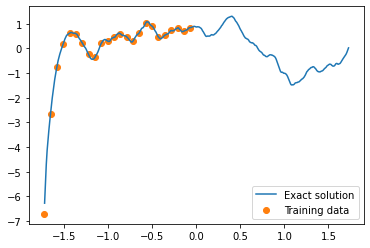

In [7]:
plt.figure()
plt.plot(time_test.numpy(),T_room_test.numpy(), label="Exact solution")
plt.scatter(time_train.numpy(),T_room_train.numpy(), color="tab:orange", label="Training data")

plt.legend()

plt.show()

In [8]:
data.describe()

,time_s,T_room_K,P_heat_W,T_out_K
count,7.200000e+02,7.200000e+02,7.200000e+02,7.200000e+02
mean,7.894919e-17,1.178317e-14,4.137123e-16,2.378344e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.728445e+00,-6.712777e+00,-2.471472e+01,-2.638245e+01
25%,-8.642226e-01,-5.951462e-01,-2.592154e-03,-9.592519e-02
50%,0.000000e+00,3.344267e-01,-2.592154e-03,6.648470e-02
75%,8.642226e-01,6.494321e-01,-2.592154e-03,1.739665e-01
max,1.728445e+00,1.301087e+00,4.358371e+00,3.853654e-01


#### Model preparation
N.B: Main focus is the loss function

In [9]:
# PINN Network
device = 'cuda' if torch.cuda.is_available() else 'cpu'
class PINN(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64, output_dim=1):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        return self.net(x)


Data concatenation to feed into model

In [10]:
x_data= torch.cat([time_train, T_out_train, P_heat_train], dim=1) ## Add time 
x=torch.cat([time_test, T_out_test, P_heat_test], dim=1)
y_data= T_room_train
y=T_room_test
print(x_data.shape,y_data.shape,x.shape,y.shape)

torch.Size([24, 3]) torch.Size([24, 1]) torch.Size([672, 3]) torch.Size([672, 1])


#### Training standard neural network

>Next, we train a standard neural network (fully connected network) to fit these training points.

>> We find that the network is able to fit the solution very closely in the vicinity of the training points, but does not learn an accurate solution outside of them.

Epoch 499, Loss: 0.135075


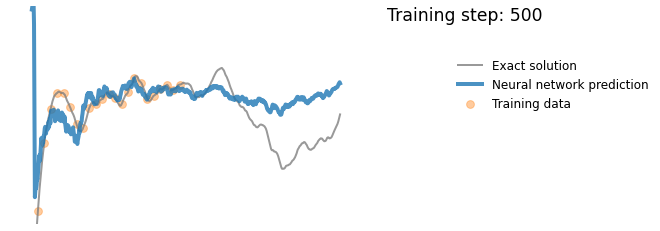

Epoch 999, Loss: 0.025079


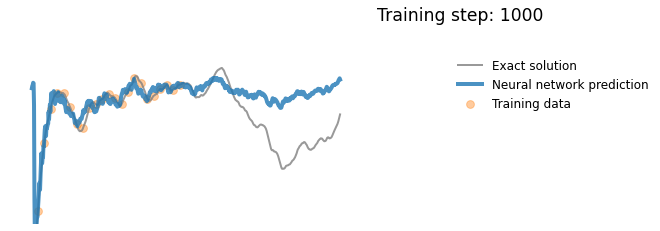

Epoch 1499, Loss: 0.014667


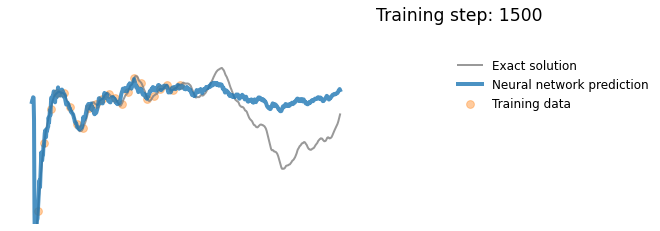

Epoch 1999, Loss: 0.010322


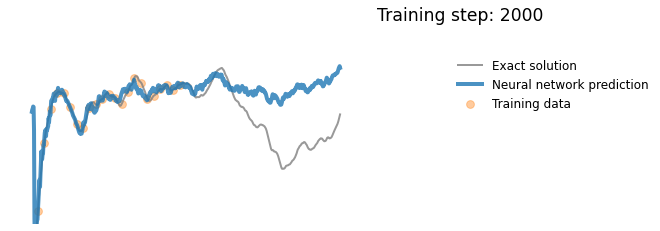

In [11]:
torch.manual_seed(1)
# Instantiate model
s_model = PINN().to(device)
optimizer = torch.optim.Adam(s_model.parameters(),lr=1e-3)
files = []
for i in range(2000):
    optimizer.zero_grad()
    yh = s_model(x_data)
    loss = torch.mean((yh-y_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()
    # plot the result as training progresses
    if (i+1) % 10 == 0: 
        yh = s_model(x).detach()
        
        plot_result(time_test,y,time_train,y_data,yh)
        file = "plots/nn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        if (i+1) % 500 == 0:
            print(f"Epoch {i}, Loss: {loss.item():.6f}")
            plt.show()
        else: plt.close("all")
            
save_gif_PIL("nn_temp.gif", files, fps=20, loop=0)

Dataset preparation for physics informed learning

In [12]:

df = data
df = df.sample(n=50, random_state=123).sort_values("time_s").reset_index(drop=True)

# Extract tensors
T_out = torch.tensor(df['T_out_K'].values).float().view(-1,1)
P_heat = torch.tensor(df['P_heat_W'].values).float().view(-1,1)
T_room = torch.tensor(df['T_room_K'].values).float().view(-1,1)
t = torch.tensor(df['time_s'].values).float().view(-1,1)

# N = len(df)
# t = torch.arange(N).float().view(-1,1)
t.requires_grad_(True)

# Training inputs (data)
x_data_phy = torch.cat([t, T_out, P_heat], dim=1)

# Physics inputs (same as data, or create more if you want)
x_phys = x_data_phy.clone()
t_phys = t
T_out_phys = T_out
P_heat_phys = P_heat

# Ground truth
py_data = T_room

#### Training the model with physics loss

> Finally, we add the underlying differential equation ("physics loss") to the loss function.

The physics loss aims to ensure that the learned solution is consistent with the underlying differential equation. This is done by penalising the residual of the differential equation over a set of locations sampled from the domain.

Here I evaluate the physics loss at 50 points uniformly spaced over the problem domain 
. We can calculate the derivatives of the network solution with respect to its input variable at these points using pytorch's autodifferentiation features, and can then easily compute the residual of the differential equation using these quantities.

> Residual Equation
$$ \frac{dT}{dt} - \frac{P_{heat} - A_{cht}(T_pred-T_{out})}{c.m} = 0  $$

Epoch 999, Loss: 0.281209


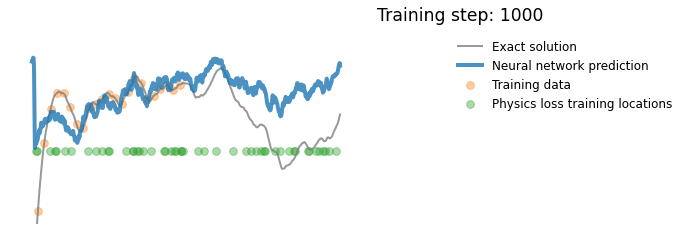

Epoch 1999, Loss: 0.251383


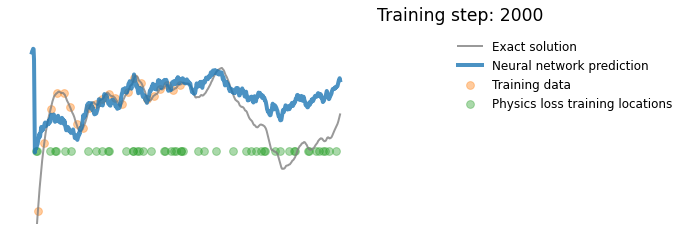

Epoch 2999, Loss: 0.211327


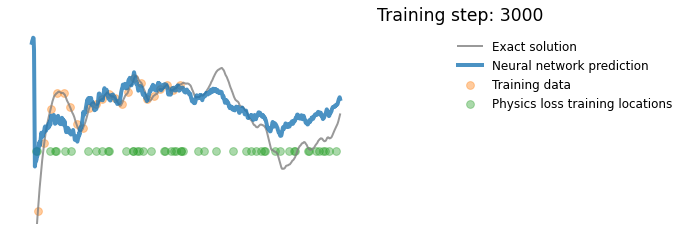

Epoch 3999, Loss: 0.158704


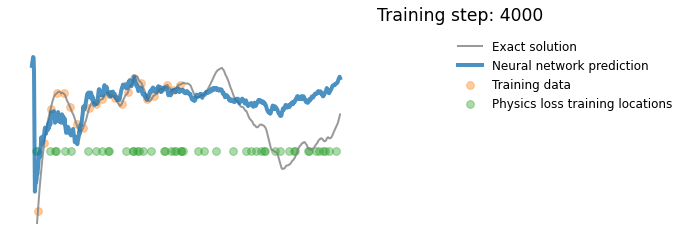

Epoch 4999, Loss: 0.050209


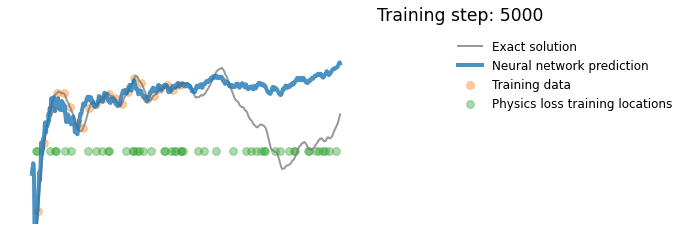

Epoch 5999, Loss: 0.029110


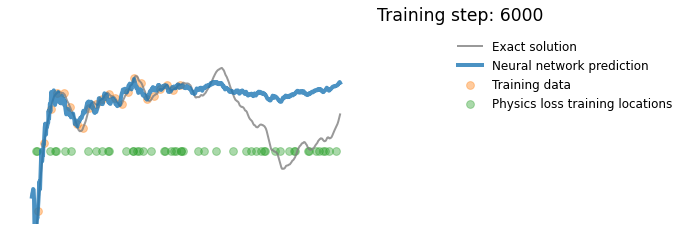

Epoch 6999, Loss: 0.023519


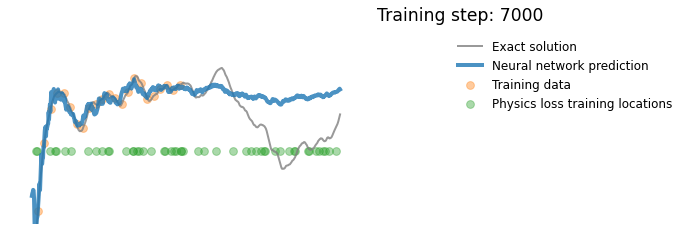

Epoch 7999, Loss: 0.017726


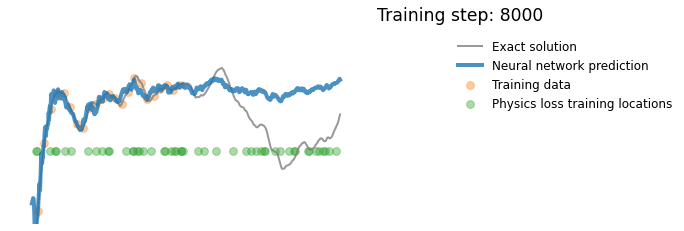

Epoch 8999, Loss: 0.012868


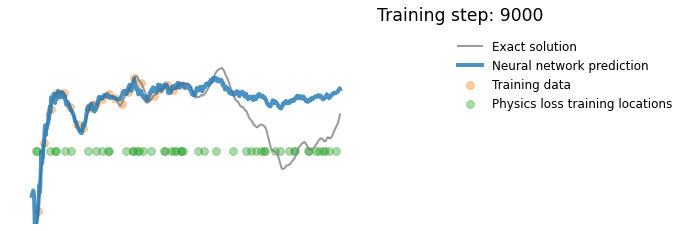

Epoch 9999, Loss: 0.009747


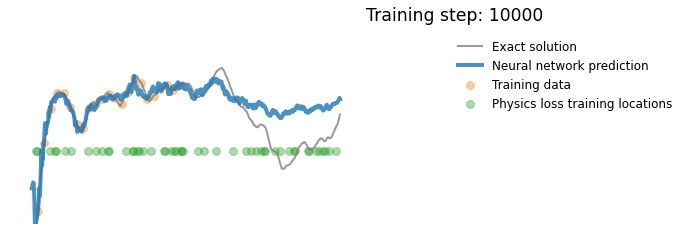

In [13]:
# ------------ TRAINING LOOP FIXED ----------------
# Instantiate model
torch.manual_seed(2)
pinn_model = PINN().to(device)
optimizer = torch.optim.Adam(pinn_model.parameters(), lr = 1e-4)
files = []


for i in range(10000):

    optimizer.zero_grad()

    # ------------------ DATA LOSS ------------------
    y_pred = pinn_model(x_data)
    loss_data = torch.mean((y_pred - y_data)**2)

    # ---------------- PHYSICS LOSS -----------------
    # Predict temperature at physics points
    y_phys = pinn_model(x_phys)

    # Compute dT/dt
    dTdt = torch.autograd.grad(
        y_phys,
        t_phys,
        grad_outputs=torch.ones_like(y_phys),
        create_graph=True
    )[0]

    # physics residual  
    phys_residual = dTdt - ( (1/(c*m)) * P_heat_phys - (A_cht/(c*m))*(y_phys - T_out_phys) )

    loss_phys = 1e-3 * torch.mean(phys_residual**2)

    # Total loss
    loss = loss_data + loss_phys
    loss.backward()
    optimizer.step()
    if (i+1) % 100 == 0:
        #print(f"Epoch {i+1}: Loss = {loss.item():.6f}")

        # Use test input for plotting
        with torch.no_grad():
            y_hat = pinn_model(x).detach()
            
            

        plot_result(time_test,y,time_train,y_data,y_hat,t.detach())
        file = "plots/nn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        if (i+1) % 1000 == 0:
            print(f"Epoch {i}, Loss: {loss.item():.6f}")
            plt.show()
        else: plt.close("all")
        
save_gif_PIL("pinn_temp.gif", files, fps=20, loop=0)


In [14]:
print('Thank you')

Thank you
